In [1]:
import psycopg2
import psycopg2.extras
import getpass
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import shapely.wkt as wkt
from shapely.geometry import Point

In [2]:
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")
db = psycopg2.connect(f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'")

db.autocommit = True

cursor = db.cursor(cursor_factory = psycopg2.extras.DictCursor)

DB User:  midorr
DB Password:  ········


In [9]:
tag = "latest"
db.rollback()
q = ("SELECT id,tag FROM versiontags WHERE tag=%(tag)s")
cursor.execute(q, {"tag": tag})
row = cursor.fetchone()
tagid = row['id']

In [10]:
# %%time
# query_elais = ("SELECT od.ra, od.dec "
#                "FROM objectdatas AS od "
#                "INNER JOIN objectdata_versiontag AS odvt ON od.id=odvt.objectdata_id AND odvt.versiontag_id=%(tagid)s "
#                "INNER JOIN objects AS o ON od.object_id=o.id "
#                "INNER JOIN images AS i ON o.image_id=i.id "
#                "INNER JOIN objectrbs as rbs ON od.id=rbs.objectdata_id AND rbs.rbtype_id=2 "
#                "INNER JOIN exposures AS e ON i.exposure_id=e.id "
#                "WHERE od.ra > 5.0 AND od.ra < 12.0 AND od.dec > -46 AND od.dec < -41 "  # isolating ELAIS field
#                "AND rbs.rb > 0.6 " 
#                "AND (e.proposalid = '2021A-0113' OR e.proposalid = '2021B-0149' OR "
#                "e.proposalid = '2022A-724693' OR e.proposalid = '2022B-762878') "
#                "LIMIT 10000000")

# cursor.execute(query_elais, {'tagid': tagid})
# radecquery_elais = np.array(cursor.fetchall()).T
# radecquery_elais = np.unique(radecquery_elais.T, axis=0).T

In [11]:
# print(len(radecquery_elais[0,:]))

In [12]:
import tarfile
fn = "tables.tar"
tf = tarfile.open(fn)
print(tf.getnames())

['table3.fits', 'table4.fits', 'table6.fits', 'tableB1.fits', 'readme.txt']


In [13]:
tf.extract('table3.fits')

In [14]:
from astropy.io import fits

radio_agn_tab = fits.open('table3.fits')

In [15]:
print(radio_agn_tab[1].columns)

ColDefs(
    name = 'Name'; format = '19A'
    name = 'ATLASID'; format = '8A'
    name = 'TractorID'; format = '25A'
    name = 'vis'; format = 'K'; null = 999999
    name = 'ext'; format = 'D'
)


In [16]:
radio_agn_data = radio_agn_tab[1].data
for i in range(5):
    print(radio_agn_data[i][0])

J032553.86-280455.0
J032554.05-284155.1
J032555.30-283744.5
J032557.32-280308.9
J032558.27-281152.3


In [17]:
len(radio_agn_data)

4851

In [18]:
radio_agn_names=[]
for i in range(4851):
    radio_agn_names.append(radio_agn_data[i][0])

In [19]:
filename = '../extragalactic_fields/candidate_nightly_epochs_files/candidate_lightcurve_parameters.dat'
realcandsarr = np.genfromtxt(filename, dtype=str)
realcands = np.unique(realcandsarr.T[1])

In [20]:
realcands

array(['DC21baaa', 'DC21baab', 'DC21babt', ..., 'DC22eclvq', 'DC22edblt',
       'DC22engvv'], dtype='<U9')

In [21]:
%%time
candcoord = []
for i in realcands:
    query = ("SELECT c.ra, c.dec FROM candidates c "
             "WHERE c.id = %s "
             "LIMIT 1")
    cursor.execute(query, (i,))
    res = np.array(cursor.fetchall())[0]
    candcoord.append([i, res])
candcoord1 = np.array([[i[0], SkyCoord(i[1][0], i[1][1], unit='deg')] for i in candcoord])

CPU times: user 1.46 s, sys: 67.1 ms, total: 1.53 s
Wall time: 3.35 s


In [22]:
print(len(realcands), len(candcoord1))

4383 4383


In [23]:
candcoord1[:2]

array([['DC21baaa', <SkyCoord (ICRS): (ra, dec) in deg
                        (150.32139125, 3.01570179)>   ],
       ['DC21baab', <SkyCoord (ICRS): (ra, dec) in deg
                        (149.07706906, 2.66553009)>   ]], dtype=object)

In [24]:
temp= SkyCoord(candcoord1.T[1])

In [25]:
from astropy import units as u
from astropy.coordinates import SkyCoord

# temp=[]
# for i in range(4851):
#     temp.append(SkyCoord(radio_agn_names[i], unit=(u.deg)))
# radio_agn_coord = np.asarray(temp)

In [26]:
radio_agn_names[4000]

'J003453.73-430500.5'

In [27]:
radio_agn_coord = SkyCoord(radio_agn_names, unit=(u.hourangle,u.deg))

(-41.0, -45.0)

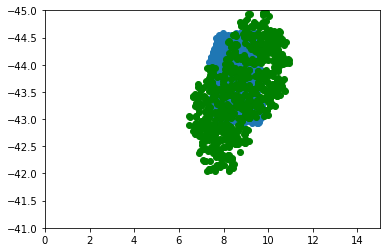

In [40]:
plt.scatter(radio_agn_coord.ra.deg, radio_agn_coord.dec.deg)
plt.scatter(temp.ra.deg, temp.dec.deg,color='green')
plt.xlim(0,15)
plt.ylim(-41,-45)

Match the datasets with a 2 arcsec radius

In [29]:
radio_agn_coord.isscalar

False

In [30]:
elais_matches = []
elais_allseps = []
for i, coord in enumerate(candcoord1.T[1]):
    idx, sep2d, dist3d = coord.match_to_catalog_sky(radio_agn_coord)
    elais_allseps.append(sep2d*3600.0)
    if sep2d < 10*u.arcsec:
        elais_matches.append([i, coord, idx, sep2d])
elais_matches = np.array(elais_matches, dtype='object')

In [35]:
elais_matches.size

104